<h1 align='center'>  HR ANALYTICS CHALLENGE </h1>
<h3 align='center'> <b>Predict Whether a Potential Promotee Will be Promoted or Not</b> </h3>

### **The Challenge**

HR analytics is revolutionising the way human resources departments operate, leading to higher efficiency and better results overall. Human resources has been using analytics for years. However, the collection, processing and analysis of data has been largely manual, and given the nature of human resources dynamics and HR KPIs, the approach has been constraining HR. Therefore, it is surprising that HR departments woke up to the utility of machine learning so late in the game. 
<br></br>
#### **Problem Statement**

Your client is a large MNC and they have 9 broad verticals across the organisation. One of the problem your client is facing is around identifying the right people for promotion (only for manager position and below) and prepare them in time. Currently the process, they are following is:

1. They first identify a set of employees based on recommendations/ past performance
2. Selected employees go through the separate training and evaluation program for each vertical. These programs are based on the required skill of each vertical
3. At the end of the program, based on various factors such as training performance, KPI completion (only employees with KPIs completed greater than 60% are considered) etc., employee gets promotion

For above mentioned process, the final promotions are only announced after the evaluation and this leads to delay in transition to their new roles. Hence, company needs your help in identifying the eligible candidates at a particular checkpoint so that they can expedite the entire promotion cycle.



## 0. Import relevant Dependencies

Incase you are getting any error saying the package is not installed while running the below cell, then you can use two methods:
- pip install ________.
- google 'How to install ________'.

In [1]:
# Import Dependencies -To see the graphs in the notebook.
%matplotlib inline   

# Python Imports
import math,time,random,datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization -This is where the graphs come in.
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Display all the columns/rows of the DataFrame.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 1. Loading the required Data

In [2]:
# Import the test data.
test = pd.read_csv('test.csv')

In [3]:
# Viewing the test dataset
test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [4]:
print("Dimensionality of the test dataset: ", test.shape)

Dimensionality of the test dataset:  (23490, 13)


## 2. Exploratory Data Analysis
**PROBLEM:** To predict whether a Potential Promotee Will be Promoted or Not

<AxesSubplot:>

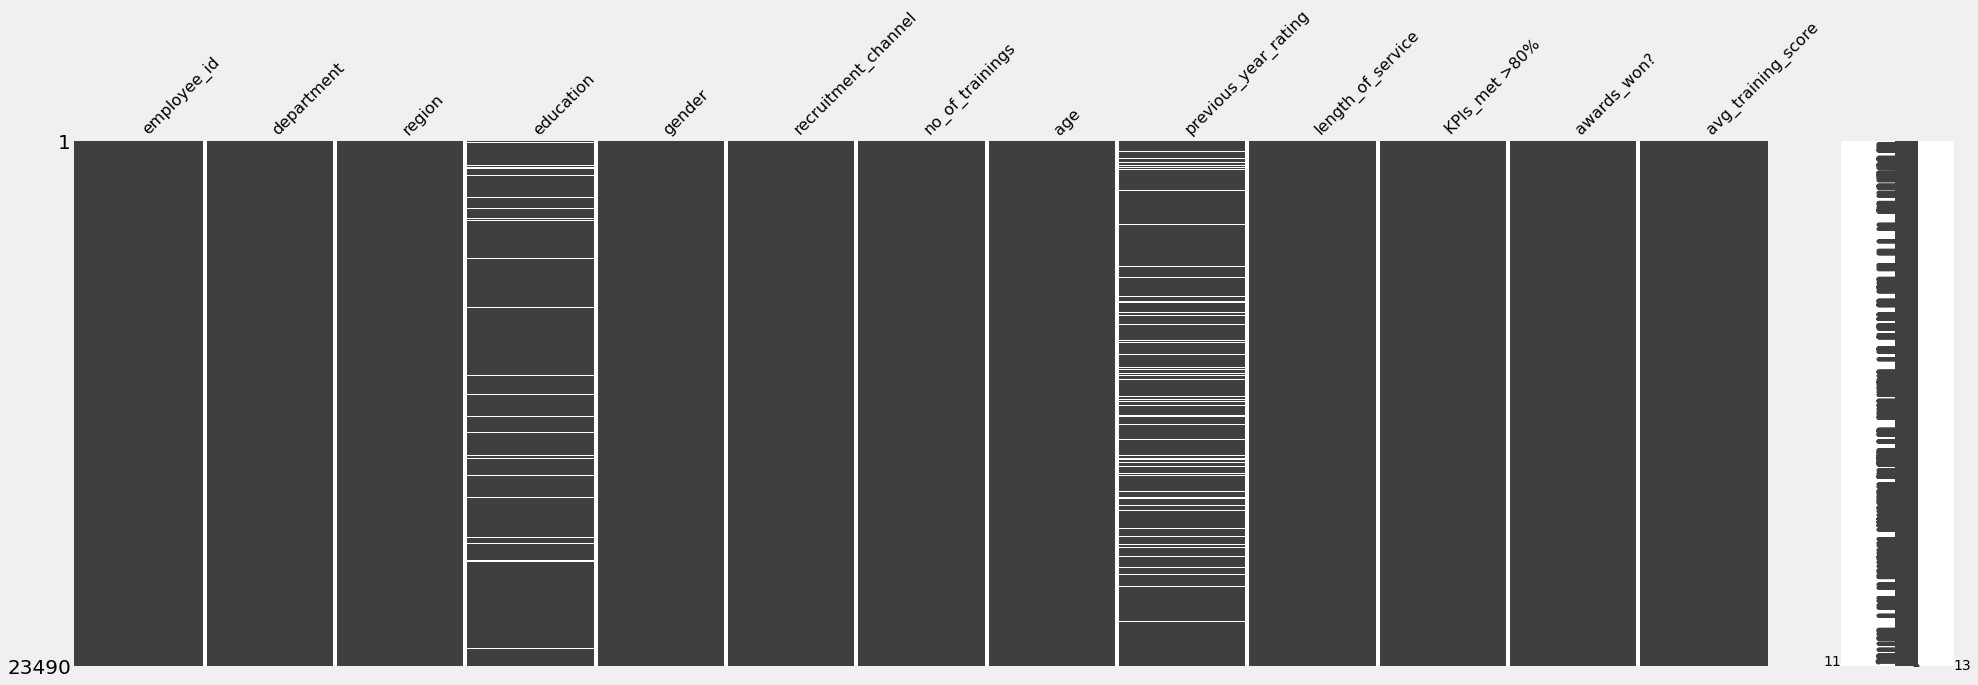

In [5]:
# To plot a graphic of missing values
missingno.matrix(test,figsize=(30,9))

> Here we can see that only two columns have Missing values and in those the "Previous Year Rating" Column is more in number. Let's understand it a bit more.

In [6]:
# Understanding more about the missing value columns

def missing_values_table(df):
    # number of missing values
    mis_val = df.isnull().sum()

    # % of missing values
    mis_val_percent = 100 * mis_val / len(df)

    # make table # axis '0' concat along index, '1' column
    mis_val_table = pd.concat([mis_val,mis_val_percent], axis= 1) 

    # rename columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0: 'Missing Values', 1: '% of Total Values'})

    # sort by column
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!= 0].sort_values(
        '% of Total Values', ascending= False).round(1) #Review
    print("Your selected dataset has " + str(df.shape[1]) + " columns and " + str(len(df)) + " observations.\n"
         "\n There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
    
    # return the dataframe with missing info
    return mis_val_table_ren_columns

missing_values_table(test)

Your selected dataset has 13 columns and 23490 observations.

 There are 2 columns that have missing values.


,Missing Values,% of Total Values
previous_year_rating,1812,7.7
education,1034,4.4


- Since we now got an idea of how the Missing Values are spread about in our dataset, we will be handling them in the Feature Engineering section.

### What Datatypes are there in the dataframe?

We usually consider features with a datatype of object as categorical features. And those with float or int could be numerical features.

However, sometimes the features that we consider as numerical might actually turn out to be categorical.

The next few steps will help us figure out how to process our data so our machine learning model can learn from it.
Ideally all the features will be encoded into a numerical value of some kind (maybe 0 or 1 / something else).

In [7]:
# Datatypes in the dataset
test.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
dtype: object

### Exploring each of these features 
We will go through each of the columns and see which all we can use in our first models. Some of them needs more preprocessing than the others to get ready.

In [8]:
test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


#### FEATURE 1: Employee_ID

In [9]:
# Checking for duplicated values.
test['employee_id'].duplicated().any()

False

In [10]:
test.drop(columns= 'employee_id', inplace= True)
test.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


#### FEATURE 2: Department

In [11]:
# Checking for any missing values
test['department'].isnull().any()

False

In [12]:
# Checking for Unique values
test['department'].unique()

array(['Technology', 'HR', 'Sales & Marketing', 'Procurement', 'Finance',
       'Analytics', 'Operations', 'Legal', 'R&D'], dtype=object)

<AxesSubplot:xlabel='count', ylabel='department'>

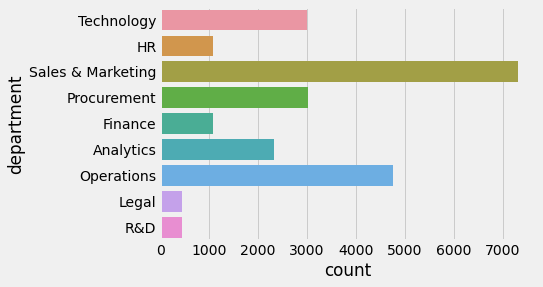

In [13]:
# Understanding how many employees are there in each department.
sns.countplot(y= test['department'])

#### FEATURE 3: Region

In [14]:
# Checking for any missing values
test['region'].isnull().any()

False

In [15]:
# Checking for Unique values
test['region'].unique()

array(['region_26', 'region_4', 'region_13', 'region_2', 'region_29',
       'region_7', 'region_22', 'region_16', 'region_17', 'region_24',
       'region_11', 'region_27', 'region_9', 'region_20', 'region_34',
       'region_23', 'region_8', 'region_14', 'region_31', 'region_19',
       'region_5', 'region_28', 'region_15', 'region_3', 'region_25',
       'region_12', 'region_21', 'region_30', 'region_10', 'region_33',
       'region_32', 'region_6', 'region_1', 'region_18'], dtype=object)

#### FEATURE 4: Education

In [16]:
# Checking for any missing values
test['education'].isnull().any()

True

In [17]:
# Checking for Unique values
test['education'].unique()

array(["Bachelor's", "Master's & above", nan, 'Below Secondary'],
      dtype=object)

<AxesSubplot:xlabel='count', ylabel='education'>

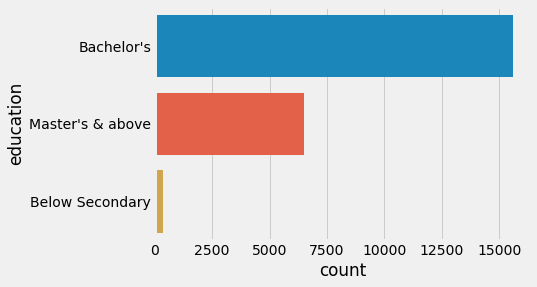

In [18]:
# Understanding the effect of Missing Values.
sns.countplot(y= test['education'])

In [19]:
test[test['education'].isnull()]['department'].unique()

array(['Sales & Marketing', 'Operations', 'Analytics', 'Technology',
       'Finance', 'Procurement', 'HR', 'R&D', 'Legal'], dtype=object)

In [20]:
Min_Edu = test[test['education'].isnull()]['department'].unique()
for i in Min_Edu:
    print((test[test['department'] == i]['education'].mode().iloc[0]), f'for {i}')
    print('Total Count', (test[test['department'] == i]['education'].isnull().sum()), f'for {i}')
    print()

Bachelor's for Sales & Marketing
Total Count 663 for Sales & Marketing

Bachelor's for Operations
Total Count 92 for Operations

Bachelor's for Analytics
Total Count 155 for Analytics

Bachelor's for Technology
Total Count 42 for Technology

Bachelor's for Finance
Total Count 14 for Finance

Bachelor's for Procurement
Total Count 40 for Procurement

Bachelor's for HR
Total Count 14 for HR

Bachelor's for R&D
Total Count 12 for R&D

Bachelor's for Legal
Total Count 2 for Legal



In [21]:
test['education'].fillna(test['education'].mode().iloc[0], inplace= True)

#### FEATURE 5: Gender

In [22]:
# Checking for any missing values
test['gender'].isnull().any()

False

In [23]:
# Checking for Unique values
test['gender'].unique()

array(['m', 'f'], dtype=object)

<AxesSubplot:xlabel='count', ylabel='gender'>

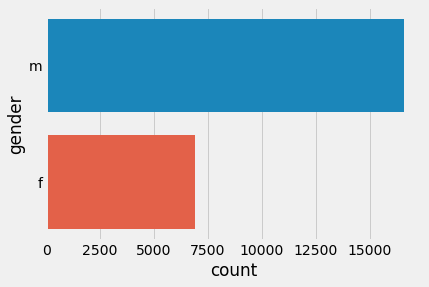

In [24]:
# Understanding the differnet Genders in the workplace.
sns.countplot(y= test['gender'])

#### FEATURE 6: Recruitment Channel

In [25]:
# Checking for any missing values
test['recruitment_channel'].isnull().any()

False

In [26]:
# Checking for Unique values
test['recruitment_channel'].unique()

array(['sourcing', 'other', 'referred'], dtype=object)

<AxesSubplot:xlabel='count', ylabel='recruitment_channel'>

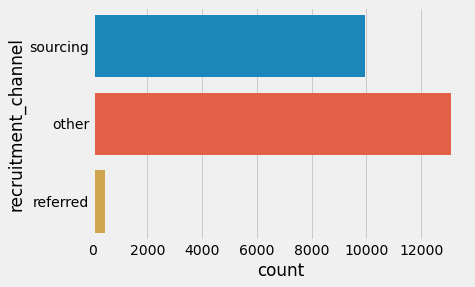

In [27]:
# Understanding how the Recruitment took place in Majority.
sns.countplot(y= test['recruitment_channel'])

#### FEATURE 7: Number of Trainings

In [28]:
# Checking for any missing values
test['no_of_trainings'].isnull().any()

False

In [29]:
# Checking for Unique values
test['no_of_trainings'].unique()

array([1, 3, 2, 4, 5, 7, 6, 8, 9], dtype=int64)

<AxesSubplot:xlabel='count', ylabel='no_of_trainings'>

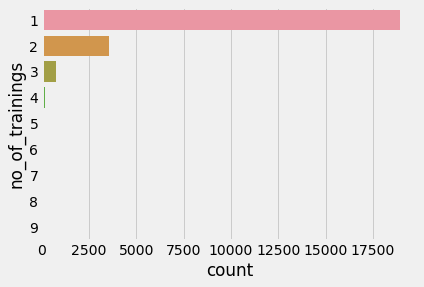

In [30]:
# Understanding the Maximum Number of Trainings taken by the employees.
sns.countplot(y= test['no_of_trainings'])

In [31]:
test['no_of_trainings'].value_counts()

1    18928
2     3544
3      755
4      190
5       36
6       24
7        9
8        2
9        2
Name: no_of_trainings, dtype: int64

#### FEATURE 8: Age

In [32]:
# Checking for any missing values
test['age'].isnull().any()

False

<AxesSubplot:xlabel='age', ylabel='Density'>

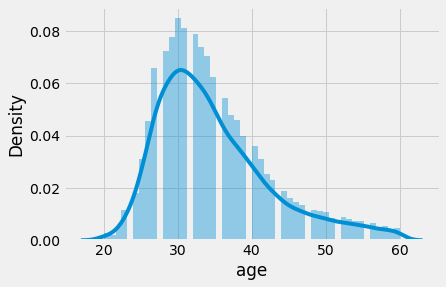

In [33]:
# Understanding the Age distribution.
sns.distplot(test['age'])

In [34]:
test['age'] = pd.cut(test['age'], bins= 5)

<AxesSubplot:xlabel='count', ylabel='age'>

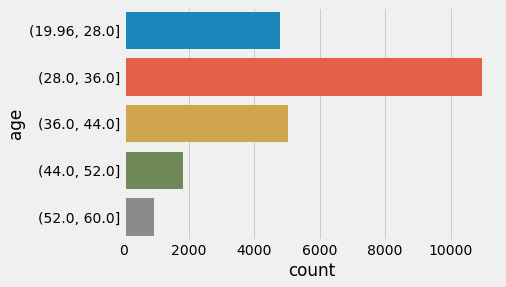

In [35]:
# Understanding the age of the employees.
sns.countplot(y= test['age'])

#### FEATURE 9: Previous Year Rating

In [36]:
# Checking for any missing values
test['previous_year_rating'].isnull().any()

True

In [37]:
# Unique Rating values.
test['previous_year_rating'].unique()

array([nan,  3.,  1.,  2.,  4.,  5.])

<AxesSubplot:xlabel='count', ylabel='previous_year_rating'>

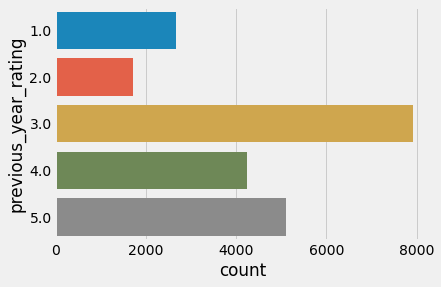

In [38]:
sns.countplot(y= test['previous_year_rating'])

In [39]:
Rating = test[test['previous_year_rating'].isnull()]['department'].unique()
for i in Rating:
    print((test[test['department'] == i]['previous_year_rating'].median()), f'for {i}')

3.0 for Technology
3.0 for Analytics
4.0 for Operations
3.0 for Legal
3.0 for Sales & Marketing
3.0 for HR
3.0 for Finance
3.0 for Procurement
4.0 for R&D


In [40]:
for i in range(0,23490):
    if(test['previous_year_rating'].isnull()[i] == True):
        if(test['department'][i] == 'Technology'):
          test['previous_year_rating'][i] = 3
        elif(test['department'][i] == 'Procurement'):
          test['previous_year_rating'][i] = 3
        elif(test['department'][i] == 'Sales & Marketing'):
          test['previous_year_rating'][i] = 3
        elif(test['department'][i] == 'Analytics'):
          test['previous_year_rating'][i] = 3
        elif(test['department'][i] == 'Finance'):
          test['previous_year_rating'][i] = 3
        elif(test['department'][i] == 'Legal'):
          test['previous_year_rating'][i] = 3
        elif(test['department'][i] == 'HR'):
          test['previous_year_rating'][i] = 3
        elif(test['department'][i] == 'Operations'):
          test['previous_year_rating'][i] = 4
        elif(test['department'][i] == 'R&D'):
          test['previous_year_rating'][i] = 4
        else:
          test['previous_year_rating'][i] = test['previous_year_rating']
    else:
      continue

In [41]:
# Unique Rating values.
test['previous_year_rating'].unique()

array([3., 1., 2., 4., 5.])

<AxesSubplot:xlabel='count', ylabel='previous_year_rating'>

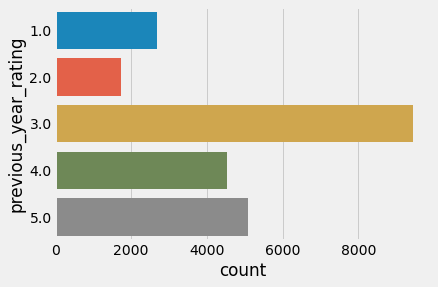

In [42]:
sns.countplot(y= test['previous_year_rating'])

#### FEATURE 10: Length of Service

In [43]:
# Checking for any missing values
test['length_of_service'].isnull().any()

False

In [44]:
# Unique Experience values.
test['length_of_service'].unique()

array([ 1,  5,  4,  9,  7,  2,  3, 11, 12, 10,  6, 14, 18,  8, 26, 13, 22,
       19, 21, 15, 16, 17, 23, 20, 31, 24, 27, 28, 25, 29, 33, 30, 34, 32],
      dtype=int64)

<AxesSubplot:xlabel='length_of_service', ylabel='Density'>

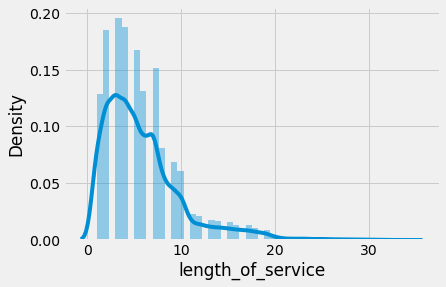

In [45]:
sns.distplot(test['length_of_service'])

#### FEATURE 11: KPI's Met

In [46]:
# Checking for any missing values
test['KPIs_met >80%'].isnull().any()

False

In [47]:
# Unique values.
test['KPIs_met >80%'].unique()

array([1, 0], dtype=int64)

<AxesSubplot:xlabel='count', ylabel='KPIs_met >80%'>

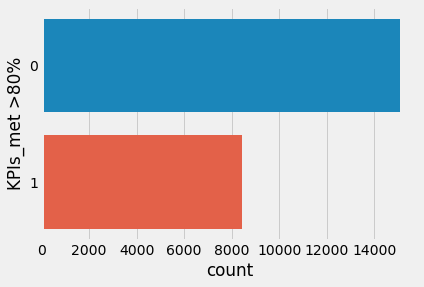

In [48]:
sns.countplot(y= test['KPIs_met >80%'])

#### FEATURE 12: Awards Won

In [49]:
# Checking for any missing values
test['awards_won?'].isnull().any()

False

In [50]:
# Unique values.
test['awards_won?'].unique()

array([0, 1], dtype=int64)

<AxesSubplot:xlabel='count', ylabel='awards_won?'>

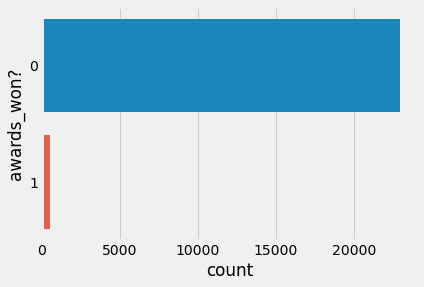

In [51]:
sns.countplot(y= test['awards_won?'])

#### FEATURE 13: Training Score

In [52]:
# Checking for any missing values
test['avg_training_score'].isnull().any()

False

<AxesSubplot:xlabel='avg_training_score', ylabel='Density'>

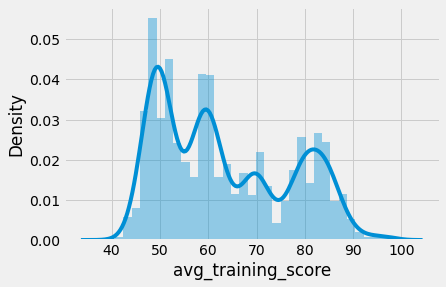

In [53]:
sns.distplot(test['avg_training_score'])

<AxesSubplot:xlabel='avg_training_score'>

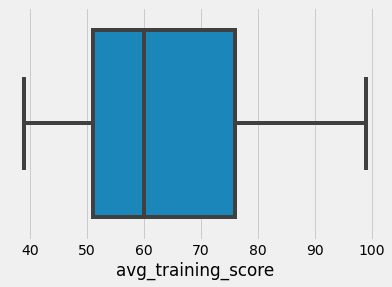

In [54]:
# Outlier Analysis
sns.boxplot(test['avg_training_score'])

### 2.2. Feature Encoding & Feature Scaling

In [55]:
test.drop(columns= 'region', inplace= True)
test['age'] = test['age'].astype(str)
test.head()

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,Technology,Bachelor's,m,sourcing,1,"(19.96, 28.0]",3.0,1,1,0,77
1,HR,Bachelor's,f,other,1,"(28.0, 36.0]",3.0,5,0,0,51
2,Sales & Marketing,Bachelor's,m,other,1,"(28.0, 36.0]",1.0,4,0,0,47
3,Procurement,Bachelor's,f,other,3,"(28.0, 36.0]",2.0,9,0,0,65
4,Finance,Bachelor's,m,sourcing,1,"(28.0, 36.0]",4.0,7,0,0,61


#### 2.2.1 Dealing with Categorical Columns (Feature Encoding)

In [56]:
# Obtaining the Categorical Columns
categorical_features = [features for features in test.columns if test[features].dtypes == 'O'] 
categorical_features

['department', 'education', 'gender', 'recruitment_channel', 'age']

In [57]:
label_encoder = LabelEncoder()
for feature in categorical_features:
    ## Encode labels in all Categorical Columns.
    test[feature]= label_encoder.fit_transform(test[feature])

test.head()

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8,0,1,2,1,0,3.0,1,1,0,77
1,2,0,0,0,1,1,3.0,5,0,0,51
2,7,0,1,0,1,1,1.0,4,0,0,47
3,5,0,0,0,3,1,2.0,9,0,0,65
4,1,0,1,2,1,1,4.0,7,0,0,61


#### 2.2.2 Dealing with Numerical Columns (Feature Scaling)

We are performing Feature Scaling because as we can see there are many Features that are measured to different units. With the help of Feature Scaling we can apply **Machine Learning Algorithms** in a better way.

In [58]:
# Obtaining Numerical Columns
numerical_features = [features for features in test.columns if test[features].dtypes != 'O'] 
numerical_features

['department',
 'education',
 'gender',
 'recruitment_channel',
 'no_of_trainings',
 'age',
 'previous_year_rating',
 'length_of_service',
 'KPIs_met >80%',
 'awards_won?',
 'avg_training_score']

In [59]:
# Selecting all Features that need to be Scaled except the Target Variable.
scale_feature = [features for features in numerical_features if features not in ['department', 'education', 'gender', 'recruitment_channel', 'age']]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


# Transform the test set and add the 'is_promoted' Column.
test = pd.concat([test[['department', 'education', 'gender', 'recruitment_channel', 'age']].reset_index(drop= True), 
       pd.DataFrame(scaler.fit_transform(test[scale_feature]), columns= scale_feature)], axis= 1) 
       ## Converting to Dataframe as after transform its an array.

test.head()

,department,education,gender,recruitment_channel,age,no_of_trainings,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8,0,1,2,0,-0.423094,-0.266732,-1.143200,1.336715,-0.152665,1.024263
1,2,0,0,0,1,-0.423094,-0.266732,-0.192590,-0.748103,-0.152665,-0.914377
2,7,0,1,0,1,-0.423094,-1.907786,-0.430243,-0.748103,-0.152665,-1.212629
3,5,0,0,0,1,2.905264,-1.087259,0.758019,-0.748103,-0.152665,0.129506
4,1,0,1,2,1,-0.423094,0.553794,0.282714,-0.748103,-0.152665,-0.168746


## 3. Feature Selection

### 3.1 Correlation

<AxesSubplot:>

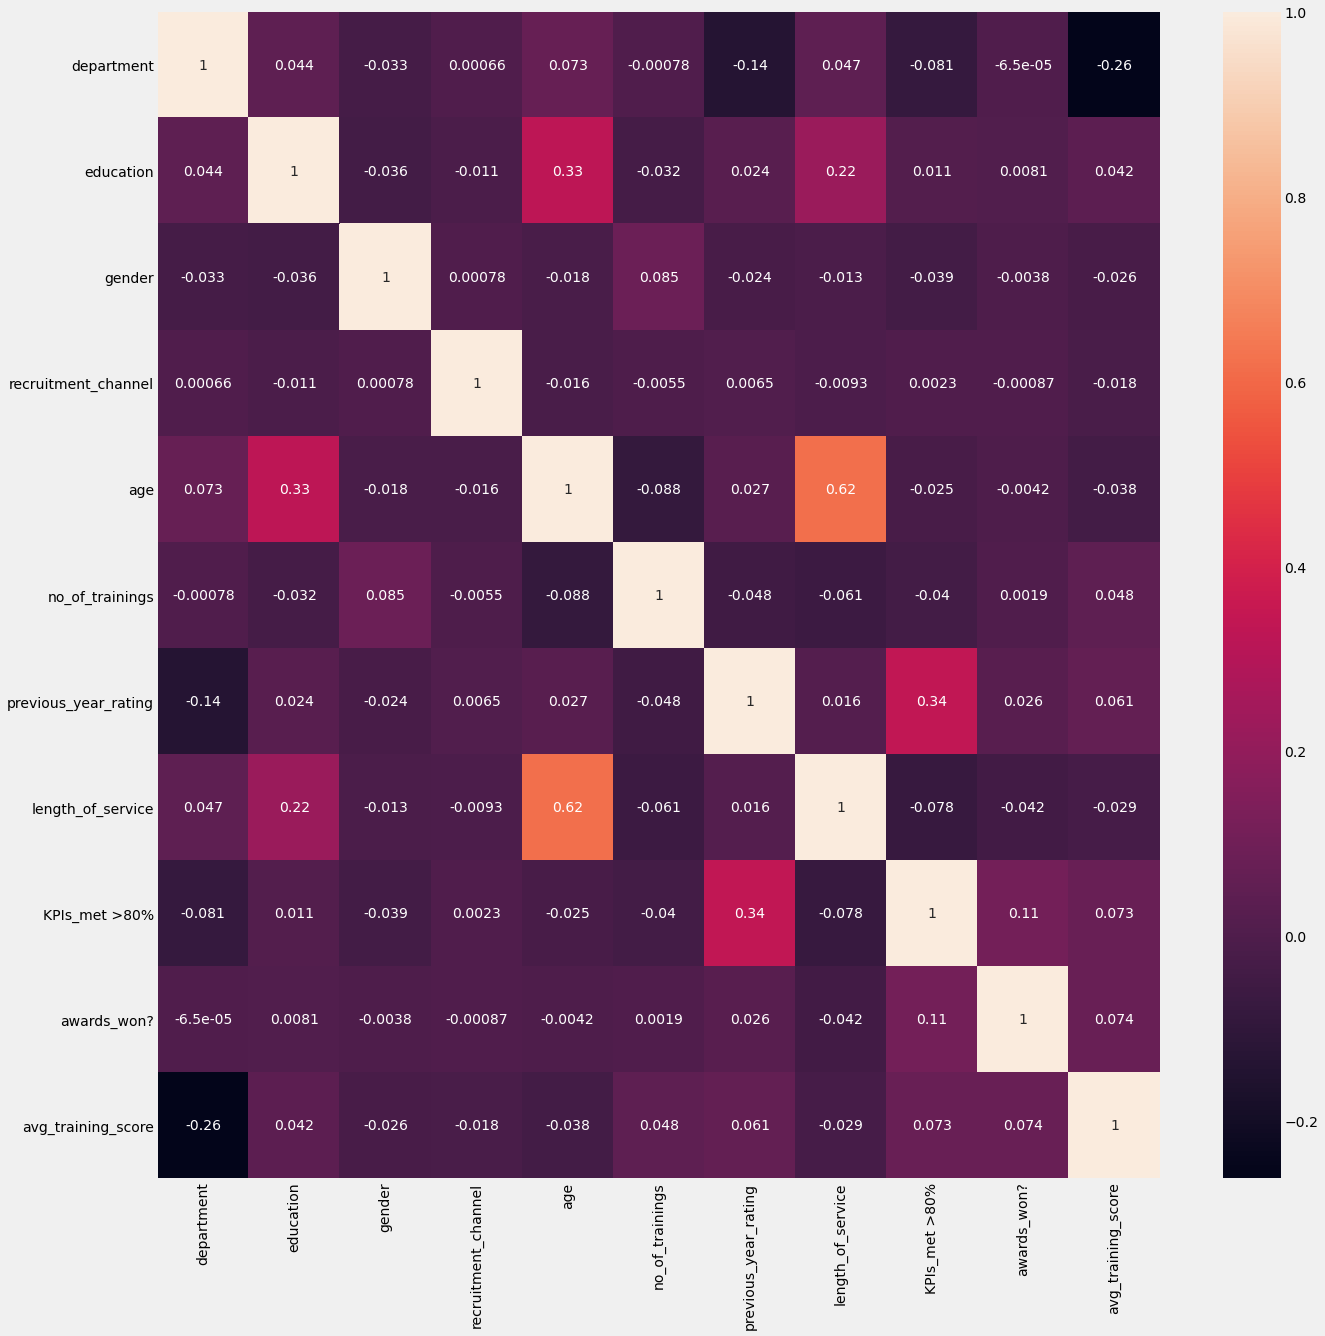

In [60]:
corr= test.corr()
top_features = corr.index

# Plotting the Correlation Plots.
plt.figure(figsize= (20,20))
sns.heatmap(test[top_features].corr(), annot= True)

In [61]:
# Dropping the Age column as it is somewhat strongly correlatedwith Length of Service.
test.drop(columns= ['age'], inplace=True)
test.head()

,department,education,gender,recruitment_channel,no_of_trainings,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8,0,1,2,-0.423094,-0.266732,-1.143200,1.336715,-0.152665,1.024263
1,2,0,0,0,-0.423094,-0.266732,-0.192590,-0.748103,-0.152665,-0.914377
2,7,0,1,0,-0.423094,-1.907786,-0.430243,-0.748103,-0.152665,-1.212629
3,5,0,0,0,2.905264,-1.087259,0.758019,-0.748103,-0.152665,0.129506
4,1,0,1,2,-0.423094,0.553794,0.282714,-0.748103,-0.152665,-0.168746


In [62]:
# convert submission dataframe to csv.
test.to_csv('Final_test.csv', index= False)
print('Final Test csv is ready')

Final Test csv is ready
